# Post processing and visualizing mandyoc data

The following notebook allows the user to visualize a given mandyoc output (e.g.: `'temperature'`, `'strain_rate'`, `'lithology'`, etc) according to a given number of time instants (e.g.: `instants = [0, 10, 20, 30]` Myr. `len(instants)` must be >= 2.

For a given instant in the `instants` the script will find the closest time step to this instant and plot the respective output.

In [1]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))


import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import glob
import os
import sys
import pylab as pl
import xarray as xr
import pymp
import mpl_toolkits.axisartist
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import string

path = os.getcwd().split('/')
machine_path = '/'+path[1]+'/'+path[2] #cat the /home/user/ or /Users/user from system using path

sys.path.insert(0, f"{machine_path}/opt/scripts/functions")
from mandyocIO import read_datasets, change_dataset, plot_property, find_nearest, plot_tracked_particles, _extract_interface

# How to plot

## In the following cell, you must inform:
 - The path to your `scenario` without `/OS_home/username` because this is collected by `machine_path`.
     - Ex.: `/mandyoc/experiments/my_experiment/`
 - The mandyoc property `prop` that you want to visualize uncommenting one the commented options.
     - `prop = 'lithology'` is the default.
 - The values in list `instants` containing the instants that you want to visualize.
     - Ex: `instants = [0, 10, 20, 30]` #Myr

In [55]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/Volumes/{external_media}"

scenarios = [
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v1/RFT_lithoramp_DT230_Tp1350oC_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lithoramp/DT230_Tp1350oC/v2/RFT_lithoramp_DT230_Tp1350oC_v2_Clc10_checkered_false",
            ]

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
            #  'strain_rate',
            #  'temperature',
            #  'temperature_anomaly',
            #  'surface',
            #  'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if ('surface' not in properties): #used to plot air/curst interface
        properties.append('surface')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('surface')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_datasets):
        properties.append('pressure')
    if ('temperature' not in new_datasets):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)
dataset3 = read_datasets(scenarios[3], new_datasets)
dataset4 = read_datasets(scenarios[4], new_datasets)
dataset5 = read_datasets(scenarios[5], new_datasets)
dataset6 = read_datasets(scenarios[6], new_datasets)
dataset7 = read_datasets(scenarios[7], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max


Nx = int(dataset0.nx)
Nz = int(dataset0.nz)
Lx = float(dataset0.lx)
Lz = float(dataset0.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(f"\n{dataset0.info}")

trackdataset0 = xr.open_dataset(f"{scenarios[0]}/_track_xzPT_all_steps.nc")
trackdataset1 = xr.open_dataset(f"{scenarios[1]}/_track_xzPT_all_steps.nc")
trackdataset2 = xr.open_dataset(f"{scenarios[2]}/_track_xzPT_all_steps.nc")
trackdataset3 = xr.open_dataset(f"{scenarios[3]}/_track_xzPT_all_steps.nc")
trackdataset4 = xr.open_dataset(f"{scenarios[4]}/_track_xzPT_all_steps.nc")
trackdataset5 = xr.open_dataset(f"{scenarios[5]}/_track_xzPT_all_steps.nc")
trackdataset6 = xr.open_dataset(f"{scenarios[6]}/_track_xzPT_all_steps.nc")
trackdataset7 = xr.open_dataset(f"{scenarios[7]}/_track_xzPT_all_steps.nc")


<bound method Dataset.info of <xarray.Dataset> Size: 2GB
Dimensions:      (x: 1601, z: 401, time: 100)
Coordinates:
  * x            (x) float64 13kB 0.0 1e+03 2e+03 ... 1.599e+06 1.6e+06
  * z            (z) float64 3kB -4e+05 -3.99e+05 -3.98e+05 ... -1e+03 0.0
  * time         (time) float64 800B 0.0 0.5 1.0 1.5 ... 38.05 38.55 39.05 39.55
    step         (time) int32 400B 0 100 200 300 400 ... 9600 9700 9800 9900
Data variables:
    strain       (time, x, z) float64 514MB ...
    density      (time, x, z) float64 514MB ...
    surface      (time, x) float64 1MB ...
    temperature  (time, x, z) float64 514MB ...
Attributes: (12/95)
    nx:                                1601
    nz:                                401
    lx:                                1600000.0
    lz:                                400000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C


In [105]:
def get_domains_coords(dataset, xl_begin, xl_end, xr_begin, xr_end):
    '''
    Get the coordinates of the domains in the rifted margins.

    Parameters
    ----------
    dataset: xarray.Dataset
        Dataset containing the properties of the model.

    idx: int
        Index of the time step to analyze.

    xl_begin: float
        Initial x position to measure the left margin.

    xl_end: float
        Final x position to measure the left margin.

    xr_begin: float
        Initial x position to measure the right margin.

    xr_end: float
        Final x position to measure the right margin.

    Returns
    -------
    '''
    
    Rhoi = dataset.density.values.T

    Nx = int(dataset.nx)
    Nz = int(dataset.nz)
    Lx = float(dataset.lx)
    Lz = float(dataset.lz)

    x = np.linspace(0, Lx/1000.0, Nx)
    z = np.linspace(-Lz/1000.0, 0, Nz)
    Z = np.linspace(-Lz/1000.0, 0, 8001) #zi

    h_air = 40.0
    topography_interface = _extract_interface(z, Z, Nx, Rhoi, 200.) + h_air
    lower_interface = _extract_interface(z, Z, Nx, Rhoi, 2900.) + h_air
    
    crustal_thickness = np.abs(lower_interface - topography_interface)
    
    #left side
    cond_xl = (x >= xl_begin) & (x <= xl_end)
    left_margin_region = crustal_thickness[cond_xl]

    # right side
    cond_xr = (x >= xr_begin) & (x <= xr_end)
    right_margin_region = crustal_thickness[cond_xr]

    # Measuring lengths of margin domains

    # left margin
    begin_necking_left = xl_begin
    idx_necking_left = np.where(left_margin_region <= 15.0)[0][0]
    end_necking_left = x[cond_xl][idx_necking_left] #first occurrence of the crustal thickness less than 15 km

    begin_hyperextended_left = end_necking_left
    idx_hyperextended_left = np.where(((left_margin_region <= 15.0) & (left_margin_region >= 2.0)))[0][-1]
    end_hyperextended_left = x[cond_xl][idx_hyperextended_left] #first occurrence of the crustal thickness less than 5 km

    # right margin
    begin_necking_right = xr_end
    # print(f"right_margin_region {right_margin_region}")
    idx_necking_right = np.where(right_margin_region <= 15.0)[0][-1]
    end_necking_right = x[cond_xr][idx_necking_right] #

    begin_hyperextended_right = end_necking_right
    idx_hyperextended_right = np.where(((right_margin_region <= 15.0) & (right_margin_region >= 2.0)))[0][0]
    end_hyperextended_right = x[cond_xr][idx_hyperextended_right] #first occurrence of the crustal

    return [begin_necking_left, end_necking_left], [begin_hyperextended_left, end_hyperextended_left], [begin_necking_right, end_necking_right], [begin_hyperextended_right, end_hyperextended_right]


IndexError: index 0 is out of bounds for axis 0 with size 0

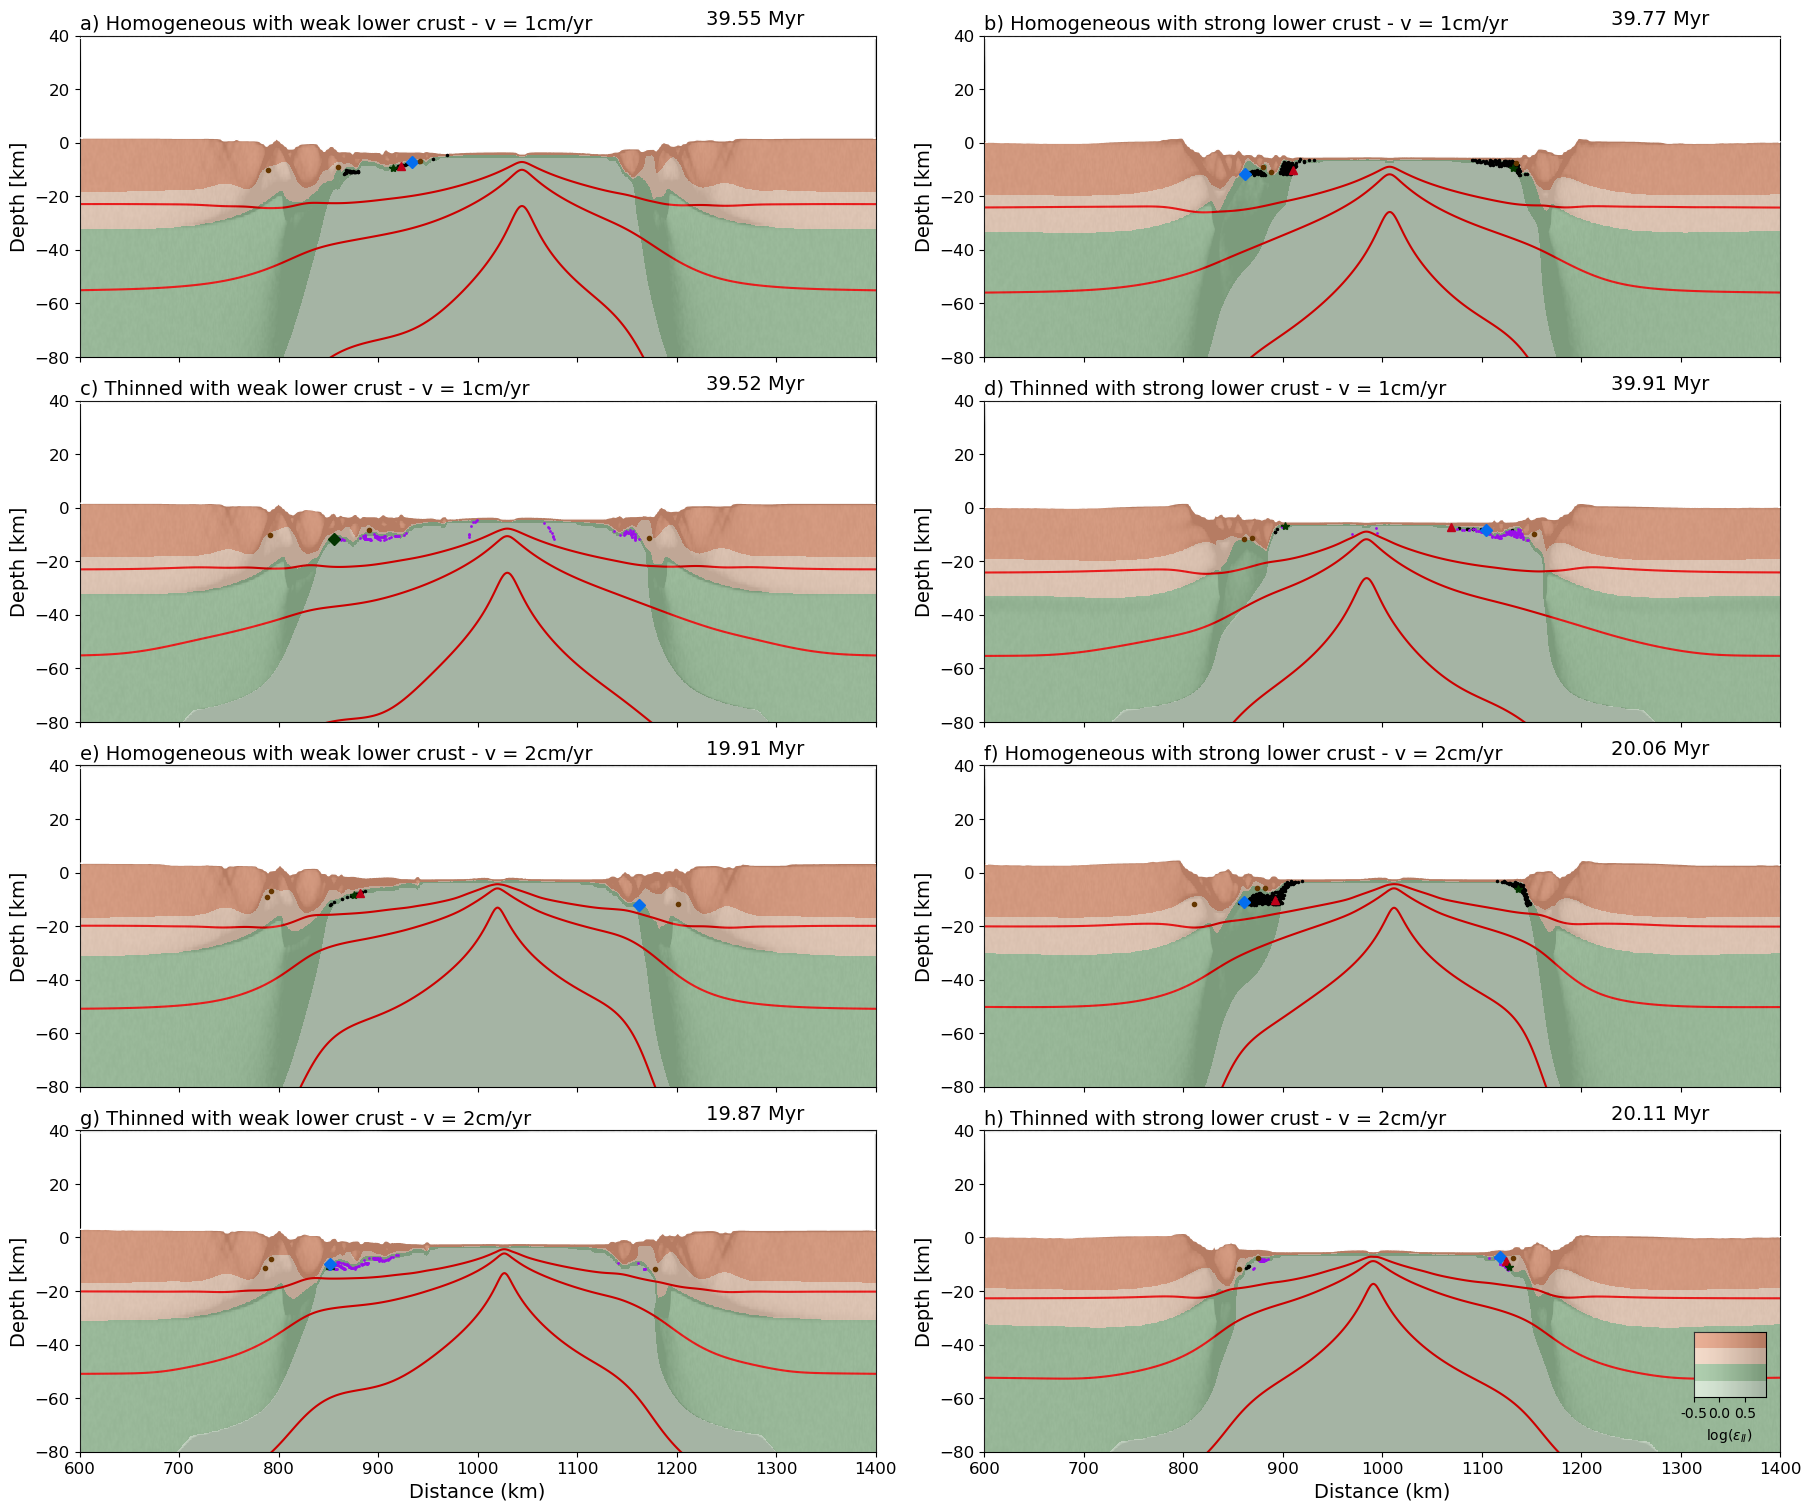

In [106]:
##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'

# instants = [0, 10., 20., 30.] #Myr

# instants = [34.59, 27.01, 30.54, 33.14] #Myr
instants = [40, 40, 40, 40, 20, 20, 20, 20] #Myr

datasets_list = [dataset0, dataset1, dataset2, dataset3, dataset4, dataset5, dataset6, dataset7]
trackdatasets_list = [trackdataset0, trackdataset1, trackdataset2, trackdataset3, trackdataset4, trackdataset5, trackdataset6, trackdataset7]

plt.close('all')

fig_height = (3.0/2.0)*(len(instants) + 2) #6 minimum
fig = plt.figure(figsize=(18, fig_height), constrained_layout=True)

mosaic = """
         AB
         CD
         EF
         GH
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.5,
                                                               0.5,
                                                               0.5,
                                                               0.5,
                                                              ]
                                             }
                        )

alphabet = list(string.ascii_uppercase)
axs_idxs = np.asarray(alphabet[0: len(scenarios)]) #starting at A subplot
idxs_aux = axs_idxs.reshape(int(len(scenarios)/2),2)

xlims = [600, 1400]
ylims = [-80, 40]
topo_from_density = True
# topo_from_density = False
plot_other_particles = True
# plot_other_particles = False

for instant, dataset, trackdataset, ax_idx in zip(instants, datasets_list, trackdatasets_list, axs_idxs):
    idx = find_nearest(dataset.time, instant)
    plot_colorbar = True if ax_idx == axs_idxs[-1] else False

    plot_property(dataset.isel(time=idx), prop, xlims, ylims, scenarios[0],
             fig,
             axs[ax_idx],
             plot_isotherms = plot_isotherms,
             topo_from_density=topo_from_density,
             plot_particles = False,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=plot_colorbar,
             bbox_to_anchor=(0.9,#horizontal position respective to parent_bbox or "loc" position
                            0.15,# vertical position
                            0.09,# width
                            0.2),
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    plot_tracked_particles(trackdataset, axs[ax_idx], idx,  plot_other_particles=plot_other_particles, color_other_particles='xkcd:black', size_other_particles=3)


fsize = 14
##########################
#Set plot details
##########################
#Titles
axs['A'].text(0.0, 1.02, f"a) Homogeneous with weak lower crust - v = 1cm/yr", transform=axs['A'].transAxes, fontsize=fsize)
axs['B'].text(0.0, 1.02, f"b) Homogeneous with strong lower crust - v = 1cm/yr", transform=axs['B'].transAxes, fontsize=fsize)
axs['C'].text(0.0, 1.02, f"c) Thinned with weak lower crust - v = 1cm/yr", transform=axs['C'].transAxes, fontsize=fsize)
axs['D'].text(0.0, 1.02, f"d) Thinned with strong lower crust - v = 1cm/yr", transform=axs['D'].transAxes, fontsize=fsize)

axs['E'].text(0.0, 1.02, f"e) Homogeneous with weak lower crust - v = 2cm/yr", transform=axs['E'].transAxes, fontsize=fsize)
axs['F'].text(0.0, 1.02, f"f) Homogeneous with strong lower crust - v = 2cm/yr", transform=axs['F'].transAxes, fontsize=fsize)
axs['G'].text(0.0, 1.02, f"g) Thinned with weak lower crust - v = 2cm/yr", transform=axs['G'].transAxes, fontsize=fsize)
axs['H'].text(0.0, 1.02, f"h) Thinned with strong lower crust - v = 2cm/yr", transform=axs['H'].transAxes, fontsize=fsize)

line_labels = np.asarray(list(string.ascii_lowercase)[0: 4])
label_fsize = 14
for ax_idx in axs_idxs:
    if(ax_idx == axs_idxs[0] or ax_idx == axs_idxs[2], ax_idx == axs_idxs[4], ax_idx == axs_idxs[6]):
        axs[ax_idx].set_ylabel('Depth [km]', fontsize=label_fsize)
    else:
        axs[ax_idx].set_yticklabels([])

    # axs[idxs_aux[i, 0]].text(-0.1, 0.95, f"{line_labels[i]})", transform=axs[idxs_aux[i, 0]].transAxes, fontsize=16)

    if(ax_idx == axs_idxs[-1] or ax_idx == axs_idxs[-2]):
        axs[ax_idx].set_xlabel('Distance (km)', fontsize=label_fsize)
    else:
        axs[ax_idx].set_xticklabels([])


#Drawring horizontal lines of margins domains
def plot_rift_domains(ax, xnecking_left, xnecking_right, xhyper_left, xhyper_right, xexhumed_left, xexhumed_right, xoceanic, z_bar,
                      color_necking = 'xkcd:dark brown',
                      color_hyperextended = 'xkcd:dark red',
                      color_exhumed_mantle = 'xkcd:bright orange',
                      color_oceanic = 'xkcd:cobalt blue',
                      lw=5):
    #Necking domain
    ax.plot(xnecking_left, z_bar, '-', color=color_necking, lw=lw, zorder=90) #left
    ax.plot(xnecking_right, z_bar, '-', color=color_necking, lw=lw, zorder=90) #right

    #Hyperextended domain
    ax.plot(xhyper_left, z_bar, color=color_hyperextended, lw=lw, zorder=90) #left
    ax.plot(xhyper_right, z_bar, color=color_hyperextended, lw=lw, zorder=90) #right

    #Exhumed mantle domain
    ax.plot(xexhumed_left, z_bar, color=color_exhumed_mantle, lw=lw, zorder=90) #left
    ax.plot(xexhumed_right, z_bar, color=color_exhumed_mantle, lw=lw, zorder=90) #right

    #Proto-oceanic/oceanic domain
    ax.plot(xoceanic, z_bar, color=color_oceanic, lw=lw, zorder=90) #left

z_bar = [10, 10]

idx = find_nearest(dataset0.time, 40) #time step to plot
#Subplot A
xneckingA_left, xhyperA_left, xneckingA_right, xhyperA_right = get_domains_coords(dataset0.isel(time=idx), xl_begin=700, xl_end=1000, xr_begin=1050, xr_end=1300)

# xneckingA_left = [700, 820]
# xhyperA_left = [820, 970]
xexhumedA_left = [970, 970]

xoceanicA = [970, 1120]

xexhumedA_right = [1130, 1130]
# xhyperA_right = [1130, 1200]
# xneckingA_right = [1200, 1300]

#Subplot B
xneckingB_left, xhyperB_left, xneckingB_right, xhyperB_right = get_domains_coords(dataset1.isel(time=idx), xl_begin=700, xl_end=1000, xr_begin=1050, xr_end=1300)
# xneckingB_left = [750, 810]
# xhyperB_left = [810, 900]
xexhumedB_left = [900, 940]

xoceanicB = [940, 1080]

xexhumedB_right = [1080, 1130]
# xhyperB_right = [1130, 1170]
# xneckingB_right = [1170, 1300]

#Subplot C
xneckingC_left, xhyperC_left, xneckingC_right, xhyperC_right = get_domains_coords(dataset2.isel(time=idx), xl_begin=700, xl_end=1000, xr_begin=1050, xr_end=1300)
# xneckingC_left = [700, 805]
# xhyperC_left = [805, 970]
xexhumedC_left = [970, 970]

xoceanicC = [970, 1100]

xexhumedC_right = [1100, 1100]
# xhyperC_right = [1100, 1180]
# xneckingC_right = [1180, 1300]

#Subplot D
xneckingD_left, xhyperD_left, xneckingD_right, xhyperD_right = get_domains_coords(dataset3.isel(time=idx), xl_begin=700, xl_end=1000, xr_begin=1050, xr_end=1300)
# xneckingD_left = [730, 820]
# xhyperD_left = [820, 890]
xexhumedD_left = [890, 905]

xoceanicD = [905, 1060]

xexhumedD_right = [1060, 1110]
# xhyperD_right = [1110, 1160]
# xneckingD_right = [1160, 1250]

#Subplot E
xneckingE_left, xhyperE_left, xneckingE_right, xhyperE_right = get_domains_coords(dataset4.isel(time=idx), xl_begin=700, xl_end=1000, xr_begin=1050, xr_end=1300)
# xneckingE_left = [700, 800]
# xhyperE_left = [800, 950]
xexhumedE_left = [950, 950]

xoceanicE = [950, 1120]

xexhumedE_right = [1120, 1120]
# xhyperE_right = [1120, 1205]
# xneckingE_right = [1205, 1300]


#Subplot F
xneckingF_left, xhyperF_left, xneckingF_right, xhyperF_right = get_domains_coords(dataset5.isel(time=idx), xl_begin=700, xl_end=1000, xr_begin=1050, xr_end=1300)
# xneckingF_left = [700, 820]
# xhyperF_left = [820, 900]
xexhumedF_left = [900, 920]

xoceanicF = [920, 1110]

xexhumedF_right = [1110, 1130]
# xhyperF_right = [1130, 1170]
# xneckingF_right = [1170, 1300]

#Subplot G
xneckingG_left, xhyperG_left, xneckingG_right, xhyperG_right = get_domains_coords(dataset6.isel(time=idx), xl_begin=700, xl_end=1000, xr_begin=1050, xr_end=1300)
# xneckingG_left = [700, 800]
# xhyperG_left = [800, 950]
xexhumedG_left = [950, 950]

xoceanicG = [950, 1120]

xexhumedG_right = [1120, 1120]
# xhyperG_right = [1120, 1160]
# xneckingG_right = [1160, 1300]

#Subplot H
xneckingH_left, xhyperH_left, xneckingH_right, xhyperH_right = get_domains_coords(dataset7.isel(time=idx), xl_begin=700, xl_end=1000, xr_begin=1050, xr_end=1300)
# xneckingH_left = [700, 820]
# xhyperH_left = [820, 890]
xexhumedH_left = [890, 890]
xoceanicH = [890, 1090]

xexhumedH_right = [1090, 1105]
# xhyperH_right = [1105, 1160]
# xneckingH_right = [1160, 1300]


color_necking = 'xkcd:dark brown'
color_hyperextended = 'xkcd:dark red'
color_exhumed_mantle = 'xkcd:bright orange'
color_oceanic = 'xkcd:cobalt blue'
lw=5

plot_rift_domains(axs['A'], xneckingA_left, xneckingA_right, xhyperA_left, xhyperA_right, xexhumedA_left, xexhumedA_right, xoceanicA, z_bar)
plot_rift_domains(axs['B'], xneckingB_left, xneckingB_right, xhyperB_left, xhyperB_right, xexhumedB_left, xexhumedB_right, xoceanicB, z_bar)
plot_rift_domains(axs['C'], xneckingC_left, xneckingC_right, xhyperC_left, xhyperC_right, xexhumedC_left, xexhumedC_right, xoceanicC, z_bar)
plot_rift_domains(axs['D'], xneckingD_left, xneckingD_right, xhyperD_left, xhyperD_right, xexhumedD_left, xexhumedD_right, xoceanicD, z_bar)
plot_rift_domains(axs['E'], xneckingE_left, xneckingE_right, xhyperE_left, xhyperE_right, xexhumedE_left, xexhumedE_right, xoceanicE, z_bar)
plot_rift_domains(axs['F'], xneckingF_left, xneckingF_right, xhyperF_left, xhyperF_right, xexhumedF_left, xexhumedF_right, xoceanicF, z_bar)
plot_rift_domains(axs['G'], xneckingG_left, xneckingG_right, xhyperG_left, xhyperG_right, xexhumedG_left, xexhumedG_right, xoceanicG, z_bar)
plot_rift_domains(axs['H'], xneckingH_left, xneckingH_right, xhyperH_left, xhyperH_right, xexhumedH_left, xexhumedH_right, xoceanicH, z_bar)


#Bars labels
ax_loc = 'A'
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_necking, lw=lw, zorder=90, label='Necking Domain')
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_hyperextended, lw=lw, zorder=90, label='Hyperextended Domain')
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_exhumed_mantle, lw=lw, zorder=90, label='Exhumed Mantle Domain')
axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_oceanic, lw=lw, zorder=90, label='Proto-oceanic/Oceanic Domain')
axs[ax_loc].legend(loc='upper center', ncol=2, fontsize=12).set_zorder(90)

# axs[ax_loc].text(0.02, 0.85, 'Necking Domain', transform=axs[ax_loc].transAxes, fontsize=14, color='xkcd:black', zorder=90)

#Symmetry
alpha=0.7
axs['A'].text(0.02, 0.05, 'Asymmetric Margins: wide x narrow\nNo Exhumed Mantle Domains', transform=axs['A'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['B'].text(0.02, 0.05, 'Asymmetric Margins: narrow x narrow\nAsymmetric Exhumed Mantle Domains', transform=axs['B'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['C'].text(0.02, 0.05, 'Asymmetric Margins: wide x narrow\nNo Exhumed Mantle Domains', transform=axs['C'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['D'].text(0.02, 0.05, 'Symmetric Margins: narrow x narrow\nAsymmetric Exhumed Mantle Domains', transform=axs['D'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)

axs['E'].text(0.02, 0.05, 'Asymmetric Margins: wide x narrow\nNo Exhumed Mantle Domains', transform=axs['E'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['F'].text(0.02, 0.05, 'Asymmetric Margins: narrow x narrow\nSymmetric Exhumed Mantle Domains', transform=axs['F'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['G'].text(0.02, 0.05, 'Asymmetric Margins: wide x narrow\nNo Exhumed Mantle Domains', transform=axs['G'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['H'].text(0.02, 0.05, 'Symmetric Margins: narrow x narrow\nAsymmetric Exhumed Mantle Domains', transform=axs['H'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)

figname = f"RHvsRT_symmetries_v1xv2_{prop}"#_TFD_{topo_from_density}"
# fig.savefig(f"figures/{figname}.png", dpi=200)
# fig.savefig(f"figures/{figname}.pdf", dpi=200)




# Comparing crustal thickness

In [6]:
#Set scenario path
local = False
if(local==True):
    model_path = machine_path
else:
    external_media = 'Joao_Macedo'
    model_path = f"/Volumes/{external_media}"

scenarios = [
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v1/RFT_DT230_Tp1350oC_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v1/RFT_DT230_Tp1350oC_crust40km_v1_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/v2/RFT_DT230_Tp1350oC_v2_Clc10_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc1_checkered_false",
            f"{model_path}/Doutorado/cenarios/mandyoc/rifting/Melting/lit120km/DT230_Tp1350oC/crust40km/v2/RFT_DT230_Tp1350oC_crust40km_v2_Clc10_checkered_false",
            ]

read_ascii = True # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
save_images = True # Generate and save all the possible images
save_big_dataset = False#True
plot_isotherms = True
# plot_melt = True
plot_melt = False

if(plot_isotherms or plot_melt):
    clean_plot=False
else:
    clean_plot = True

datasets = [#Properties from mandyoc. Comment/uncomment to select properties of the dataset
            'density',
            'radiogenic_heat',
            'pressure',
            'strain',
            'strain_rate',### Read ascii outputs and save them as xarray.Datasets,
            'surface',
            'temperature',
            'viscosity'
            ]# Read data and convert them to xarray.Dataset

properties = [#Properties from mandyoc. Comment/uncomment to select which ones you would like to plot
            #  'density',
#              'radiogenic_heat',
             'lithology',
#              'pressure',
            #  'strain',
            #  'strain_rate',
            #  'temperature',
            #  'temperature_anomaly',
            #  'surface',
            #  'viscosity'
             ]

# Read ascii outputs and save them as xarray.Datasets

new_datasets = change_dataset(properties, datasets)

to_remove = []
remove_density=False
if ('density' not in properties): #used to plot air/curst interface
        properties.append('density')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('density')
        # remove_density=True

if ('surface' not in properties): #used to plot air/curst interface
        properties.append('surface')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('surface')
        # remove_density=True

if (plot_isotherms): #add datasets needed to plot isotherms
    if ('temperature' not in new_datasets):
        properties.append('temperature')
        new_datasets = change_dataset(properties, datasets)
        to_remove.append('temperature')

# print(f"newdataset4 {new_datasets}")

if (plot_melt): #add datasets needed to plot melt fraction
    if ('pressure' not in new_datasets):
        properties.append('pressure')
    if ('temperature' not in new_datasets):
        properties.append('temperature')
    new_datasets = change_dataset(properties, datasets)

    #removing the auxiliary datasets to not plot
    to_remove.append('pressure')
    to_remove.append('temperature')

if(clean_plot): #a clean plot
    new_datasets = change_dataset(properties, datasets)

for item in to_remove:
    properties.remove(item)

dataset0 = read_datasets(scenarios[0], new_datasets)
dataset1 = read_datasets(scenarios[1], new_datasets)
dataset2 = read_datasets(scenarios[2], new_datasets)
dataset3 = read_datasets(scenarios[3], new_datasets)
dataset4 = read_datasets(scenarios[4], new_datasets)
dataset5 = read_datasets(scenarios[5], new_datasets)
dataset6 = read_datasets(scenarios[6], new_datasets)
dataset7 = read_datasets(scenarios[7], new_datasets)

# Normalize velocity values
if ("velocity_x" and "velocity_z") in dataset0.data_vars:
    v_max = np.max((dataset0.velocity_x**2 + dataset0.velocity_z**2)**(0.5))    
    dataset0.velocity_x[:] = dataset0.velocity_x[:] / v_max
    dataset0.velocity_z[:] = dataset0.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset1.data_vars:
    v_max = np.max((dataset1.velocity_x**2 + dataset1.velocity_z**2)**(0.5))    
    dataset1.velocity_x[:] = dataset1.velocity_x[:] / v_max
    dataset1.velocity_z[:] = dataset1.velocity_z[:] / v_max

if ("velocity_x" and "velocity_z") in dataset2.data_vars:
    v_max = np.max((dataset2.velocity_x**2 + dataset2.velocity_z**2)**(0.5))    
    dataset2.velocity_x[:] = dataset2.velocity_x[:] / v_max
    dataset2.velocity_z[:] = dataset2.velocity_z[:] / v_max


Nx = int(dataset0.nx)
Nz = int(dataset0.nz)
Lx = float(dataset0.lx)
Lz = float(dataset0.lz)

x = np.linspace(0, Lx/1000.0, Nx)
z = np.linspace(Lz/1000.0, 0, Nz)
xx, zz  = np.meshgrid(x, z)

print(f"\n{dataset0.info}")

trackdataset0 = xr.open_dataset(f"{scenarios[0]}/_track_xzPT_all_steps.nc")
trackdataset1 = xr.open_dataset(f"{scenarios[1]}/_track_xzPT_all_steps.nc")
trackdataset2 = xr.open_dataset(f"{scenarios[2]}/_track_xzPT_all_steps.nc")
trackdataset3 = xr.open_dataset(f"{scenarios[3]}/_track_xzPT_all_steps.nc")
trackdataset4 = xr.open_dataset(f"{scenarios[4]}/_track_xzPT_all_steps.nc")
trackdataset5 = xr.open_dataset(f"{scenarios[5]}/_track_xzPT_all_steps.nc")
trackdataset6 = xr.open_dataset(f"{scenarios[6]}/_track_xzPT_all_steps.nc")
trackdataset7 = xr.open_dataset(f"{scenarios[7]}/_track_xzPT_all_steps.nc")


<bound method Dataset.info of <xarray.Dataset> Size: 2GB
Dimensions:      (x: 1601, z: 401, time: 100)
Coordinates:
  * x            (x) float64 13kB 0.0 1e+03 2e+03 ... 1.599e+06 1.6e+06
  * z            (z) float64 3kB -4e+05 -3.99e+05 -3.98e+05 ... -1e+03 0.0
  * time         (time) float64 800B 0.0 0.5 1.0 1.5 ... 38.05 38.55 39.05 39.55
    step         (time) int32 400B 0 100 200 300 400 ... 9600 9700 9800 9900
Data variables:
    strain       (time, x, z) float64 514MB ...
    density      (time, x, z) float64 514MB ...
    surface      (time, x) float64 1MB ...
    temperature  (time, x, z) float64 514MB ...
Attributes: (12/95)
    nx:                                1601
    nz:                                401
    lx:                                1600000.0
    lz:                                400000.0
    multigrid:                         1
    solver:                            direct
    ...                                ...
    temperature_units:                 C


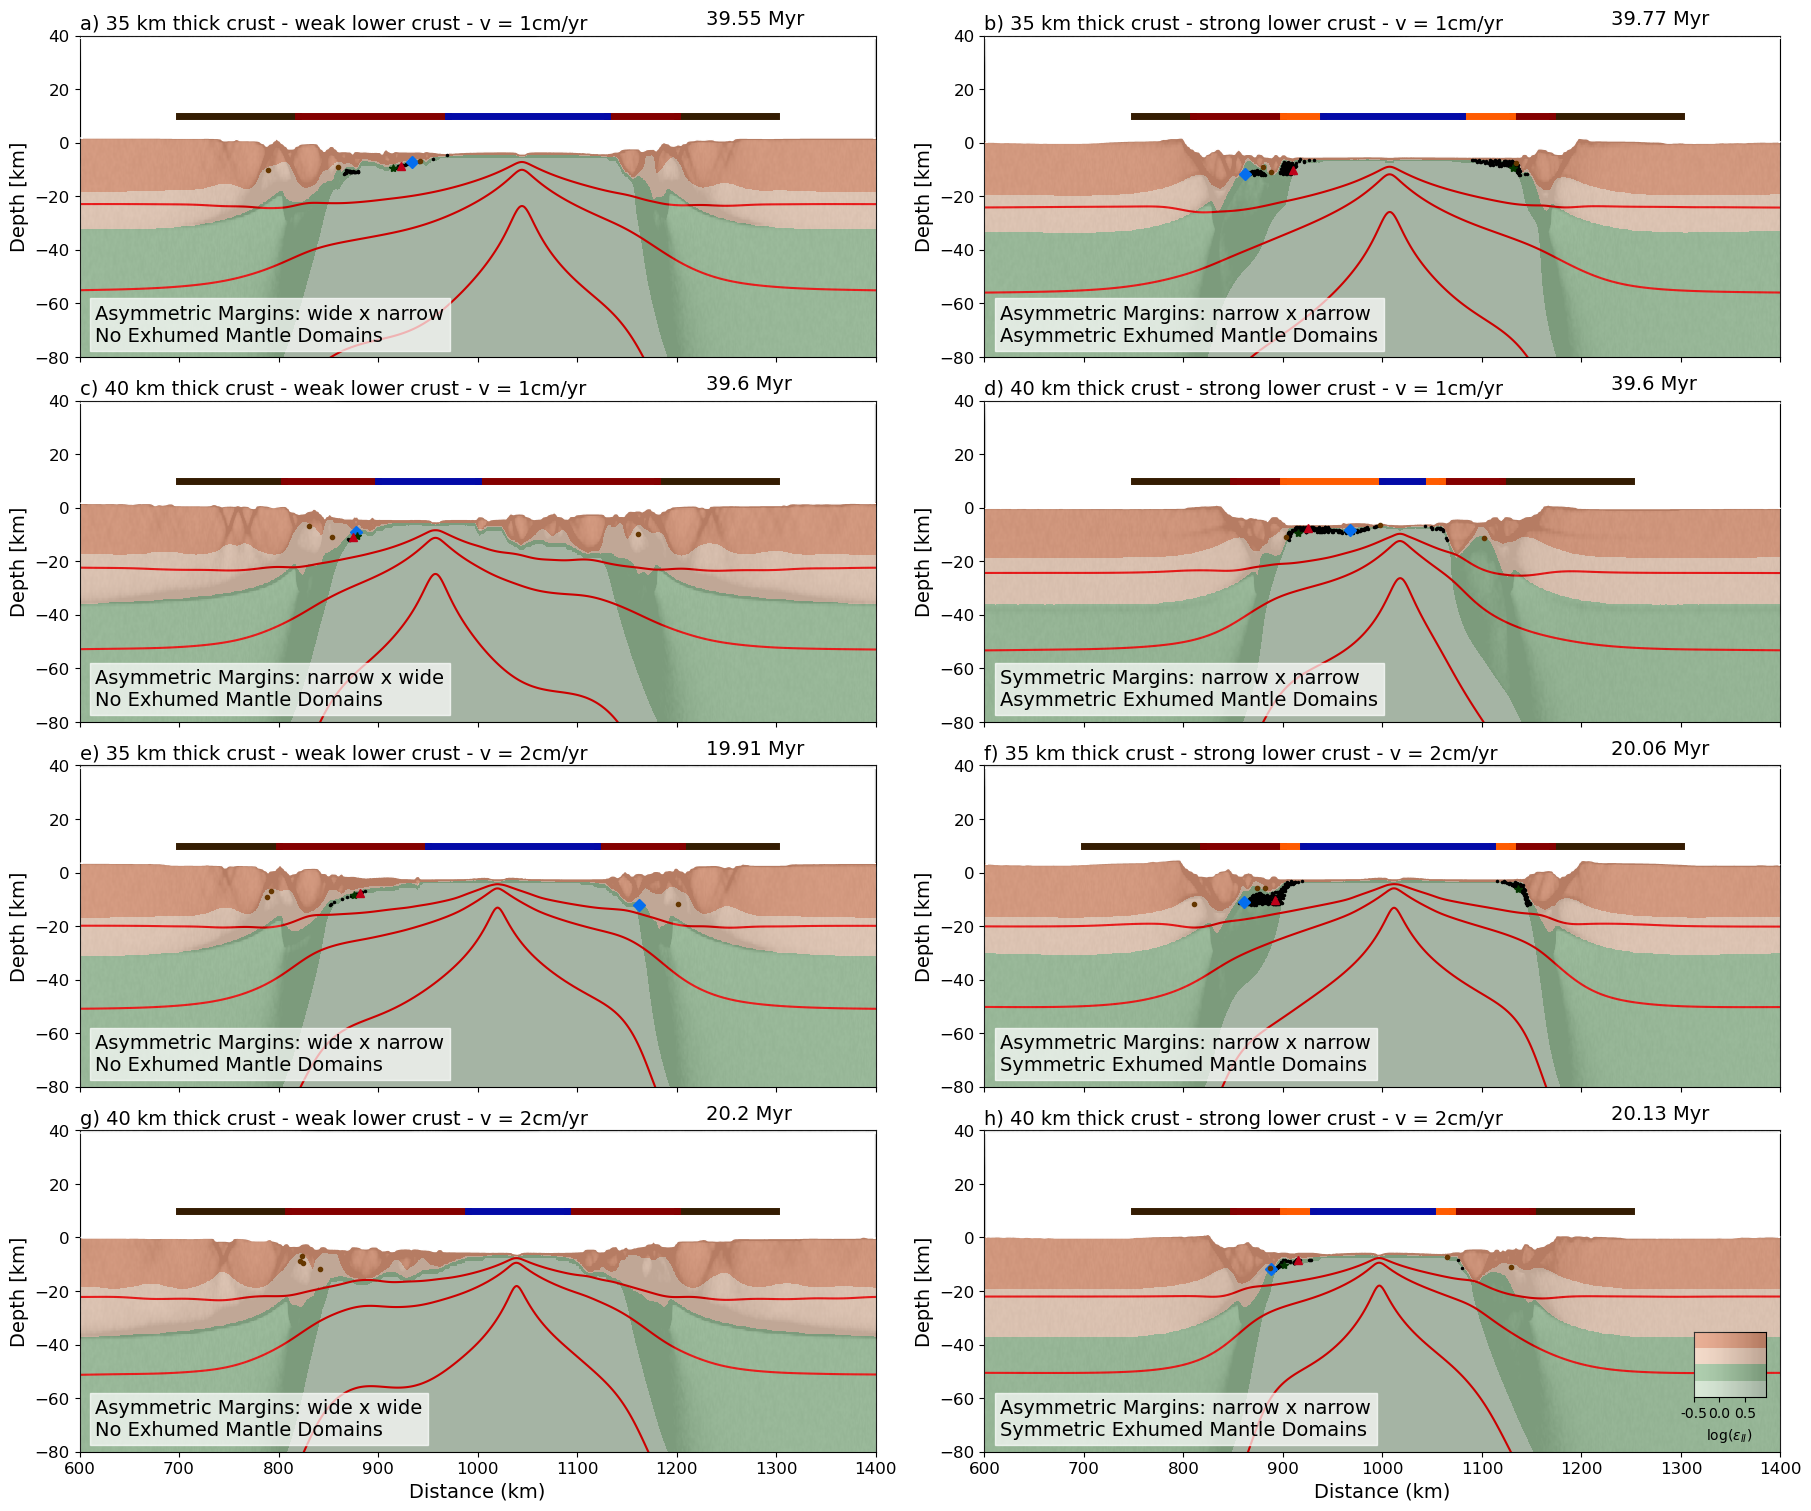

In [7]:
##############################################################################################################
#Set mandyoc property

# prop = 'density'
# prop = 'heat'
prop = 'lithology'
# prop = 'pressure'
# prop = 'strain'
# prop = 'strain_rate'
# prop = 'temperature'
# prop = 'temperature_anomaly'
# prop = 'viscosity'
# prop = 'surface'

# instants = [0, 10., 20., 30.] #Myr

# instants = [34.59, 27.01, 30.54, 33.14] #Myr
instants = [40, 40, 40, 40, 20, 20, 20, 20] #Myr

datasets_list = [dataset0, dataset1, dataset2, dataset3, dataset4, dataset5, dataset6, dataset7]
trackdatasets_list = [trackdataset0, trackdataset1, trackdataset2, trackdataset3, trackdataset4, trackdataset5, trackdataset6, trackdataset7]

plt.close('all')

fig_height = (3.0/2.0)*(len(instants) + 2) #6 minimum
fig = plt.figure(figsize=(18, fig_height), constrained_layout=True)

mosaic = """
         AB
         CD
         EF
         GH
         """
axs = fig.subplot_mosaic(mosaic, gridspec_kw={'height_ratios':[0.5,
                                                               0.5,
                                                               0.5,
                                                               0.5,
                                                              ]
                                             }
                        )

alphabet = list(string.ascii_uppercase)
axs_idxs = np.asarray(alphabet[0: len(scenarios)]) #starting at A subplot
idxs_aux = axs_idxs.reshape(int(len(scenarios)/2),2)

xlims = [600, 1400]
ylims = [-80, 40]
topo_from_density = True
# topo_from_density = False
plot_other_particles = True
# plot_other_particles = False

for instant, dataset, trackdataset, ax_idx in zip(instants, datasets_list, trackdatasets_list, axs_idxs):
    idx = find_nearest(dataset.time, instant)
    plot_colorbar = True if ax_idx == axs_idxs[-1] else False

    plot_property(dataset.isel(time=idx), prop, xlims, ylims, scenarios[0],
             fig,
             axs[ax_idx],
             plot_isotherms = plot_isotherms,
             topo_from_density=topo_from_density,
             plot_particles = False,
             particle_size = 0.2,
             particle_marker = ".",
             ncores = 20,
            #  step_plot = 4,
             isotherms = [500, 800, 1300],
             plot_colorbar=plot_colorbar,
             bbox_to_anchor=(0.9,#horizontal position respective to parent_bbox or "loc" position
                            0.15,# vertical position
                            0.09,# width
                            0.2),
             # plot_melt = plot_melt,
             # melt_method = melt_method,
            )
    plot_tracked_particles(trackdataset, axs[ax_idx], idx,  plot_other_particles=plot_other_particles, color_other_particles='xkcd:black', size_other_particles=3)


fsize = 14
##########################
#Set plot details
##########################
#Titles
axs['A'].text(0.0, 1.02, f"a) 35 km thick crust - weak lower crust - v = 1cm/yr", transform=axs['A'].transAxes, fontsize=fsize)
axs['B'].text(0.0, 1.02, f"b) 35 km thick crust - strong lower crust - v = 1cm/yr", transform=axs['B'].transAxes, fontsize=fsize)
axs['C'].text(0.0, 1.02, f"c) 40 km thick crust - weak lower crust - v = 1cm/yr", transform=axs['C'].transAxes, fontsize=fsize)
axs['D'].text(0.0, 1.02, f"d) 40 km thick crust - strong lower crust - v = 1cm/yr", transform=axs['D'].transAxes, fontsize=fsize)

axs['E'].text(0.0, 1.02, f"e) 35 km thick crust - weak lower crust - v = 2cm/yr", transform=axs['E'].transAxes, fontsize=fsize)
axs['F'].text(0.0, 1.02, f"f) 35 km thick crust - strong lower crust - v = 2cm/yr", transform=axs['F'].transAxes, fontsize=fsize)
axs['G'].text(0.0, 1.02, f"g) 40 km thick crust - weak lower crust - v = 2cm/yr", transform=axs['G'].transAxes, fontsize=fsize)
axs['H'].text(0.0, 1.02, f"h) 40 km thick crust - strong lower crust - v = 2cm/yr", transform=axs['H'].transAxes, fontsize=fsize)

line_labels = np.asarray(list(string.ascii_lowercase)[0: 4])
label_fsize = 14
for ax_idx in axs_idxs:
    if(ax_idx == axs_idxs[0] or ax_idx == axs_idxs[2], ax_idx == axs_idxs[4], ax_idx == axs_idxs[6]):
        axs[ax_idx].set_ylabel('Depth [km]', fontsize=label_fsize)
    else:
        axs[ax_idx].set_yticklabels([])

    # axs[idxs_aux[i, 0]].text(-0.1, 0.95, f"{line_labels[i]})", transform=axs[idxs_aux[i, 0]].transAxes, fontsize=16)

    if(ax_idx == axs_idxs[-1] or ax_idx == axs_idxs[-2]):
        axs[ax_idx].set_xlabel('Distance (km)', fontsize=label_fsize)
    else:
        axs[ax_idx].set_xticklabels([])


#Drawring horizontal lines of margins domains
def plot_rift_domains(ax, xnecking_left, xnecking_right, xhyper_left, xhyper_right, xexhumed_left, xexhumed_right, xoceanic, z_bar,
                      color_necking = 'xkcd:dark brown',
                      color_hyperextended = 'xkcd:dark red',
                      color_exhumed_mantle = 'xkcd:bright orange',
                      color_oceanic = 'xkcd:cobalt blue',
                      lw=5):
    #Necking domain
    ax.plot(xnecking_left, z_bar, '-', color=color_necking, lw=lw, zorder=90) #left
    ax.plot(xnecking_right, z_bar, '-', color=color_necking, lw=lw, zorder=90) #right

    #Hyperextended domain
    ax.plot(xhyper_left, z_bar, color=color_hyperextended, lw=lw, zorder=90) #left
    ax.plot(xhyper_right, z_bar, color=color_hyperextended, lw=lw, zorder=90) #right

    #Exhumed mantle domain
    ax.plot(xexhumed_left, z_bar, color=color_exhumed_mantle, lw=lw, zorder=90) #left
    ax.plot(xexhumed_right, z_bar, color=color_exhumed_mantle, lw=lw, zorder=90) #right

    #Proto-oceanic/oceanic domain
    ax.plot(xoceanic, z_bar, color=color_oceanic, lw=lw, zorder=90) #left

z_bar = [10, 10]

#Subplot A
xneckingA_left = [700, 820]
xhyperA_left = [820, 970]
xexhumedA_left = [970, 970]

xoceanicA = [970, 1130]

xexhumedA_right = [1130, 1130]
xhyperA_right = [1130, 1200]
xneckingA_right = [1200, 1300]

#Subplot B
xneckingB_left = [750, 810]
xhyperB_left = [810, 900]
xexhumedB_left = [900, 940]

xoceanicB = [940, 1080]

xexhumedB_right = [1080, 1130]
xhyperB_right = [1130, 1170]
xneckingB_right = [1170, 1300]

#Subplot C
xneckingC_left = [700, 805]
xhyperC_left = [805, 900]
xexhumedC_left = [900, 900]

xoceanicC = [900, 1000]

xexhumedC_right = [1000, 1000]
xhyperC_right = [1000, 1180]
xneckingC_right = [1180, 1300]

#Subplot D
xneckingD_left = [750, 850]
xhyperD_left = [850, 900]
xexhumedD_left = [900, 1000]

xoceanicD = [1000, 1040]

xexhumedD_right = [1040, 1060]
xhyperD_right = [1060, 1120]
xneckingD_right = [1120, 1250]

#Subplot E
xneckingE_left = [700, 800]
xhyperE_left = [800, 950]
xexhumedE_left = [950, 950]

xoceanicE = [950, 1120]

xexhumedE_right = [1120, 1120]
xhyperE_right = [1120, 1205]
xneckingE_right = [1205, 1300]


#Subplot F
xneckingF_left = [700, 820]
xhyperF_left = [820, 900]
xexhumedF_left = [900, 920]

xoceanicF = [920, 1110]

xexhumedF_right = [1110, 1130]
xhyperF_right = [1130, 1170]
xneckingF_right = [1170, 1300]

#Subplot G
xneckingG_left = [700, 810]
xhyperG_left = [810, 990]
xexhumedG_left = [990, 990]

xoceanicG = [990, 1090]

xexhumedG_right = [1090, 1090]
xhyperG_right = [1090, 1200]
xneckingG_right = [1200, 1300]

#Subplot H
xneckingH_left = [750, 850]
xhyperH_left = [850, 900]
xexhumedH_left = [900, 930]
xoceanicH = [930, 1050]

xexhumedH_right = [1050, 1070]
xhyperH_right = [1070, 1150]
xneckingH_right = [1150, 1250]


color_necking = 'xkcd:dark brown'
color_hyperextended = 'xkcd:dark red'
color_exhumed_mantle = 'xkcd:bright orange'
color_oceanic = 'xkcd:cobalt blue'
lw=5

plot_rift_domains(axs['A'], xneckingA_left, xneckingA_right, xhyperA_left, xhyperA_right, xexhumedA_left, xexhumedA_right, xoceanicA, z_bar)
plot_rift_domains(axs['B'], xneckingB_left, xneckingB_right, xhyperB_left, xhyperB_right, xexhumedB_left, xexhumedB_right, xoceanicB, z_bar)
plot_rift_domains(axs['C'], xneckingC_left, xneckingC_right, xhyperC_left, xhyperC_right, xexhumedC_left, xexhumedC_right, xoceanicC, z_bar)
plot_rift_domains(axs['D'], xneckingD_left, xneckingD_right, xhyperD_left, xhyperD_right, xexhumedD_left, xexhumedD_right, xoceanicD, z_bar)
plot_rift_domains(axs['E'], xneckingE_left, xneckingE_right, xhyperE_left, xhyperE_right, xexhumedE_left, xexhumedE_right, xoceanicE, z_bar)
plot_rift_domains(axs['F'], xneckingF_left, xneckingF_right, xhyperF_left, xhyperF_right, xexhumedF_left, xexhumedF_right, xoceanicF, z_bar)
plot_rift_domains(axs['G'], xneckingG_left, xneckingG_right, xhyperG_left, xhyperG_right, xexhumedG_left, xexhumedG_right, xoceanicG, z_bar)
plot_rift_domains(axs['H'], xneckingH_left, xneckingH_right, xhyperH_left, xhyperH_right, xexhumedH_left, xexhumedH_right, xoceanicH, z_bar)


# #Bars labels
# ax_loc = 'A'
# axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_necking, lw=lw, zorder=90, label='Necking Domain')
# axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_hyperextended, lw=lw, zorder=90, label='Hyperextended Domain')
# axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_exhumed_mantle, lw=lw, zorder=90, label='Exhumed Mantle Domain')
# axs[ax_loc].plot([-100, -100], [-100, -100], '-', color=color_oceanic, lw=lw, zorder=90, label='Proto-oceanic/Oceanic Domain')
# axs[ax_loc].legend(loc='upper center', ncol=2, fontsize=12).set_zorder(90)

# axs[ax_loc].text(0.02, 0.85, 'Necking Domain', transform=axs[ax_loc].transAxes, fontsize=14, color='xkcd:black', zorder=90)

#Symmetry
alpha=0.7
axs['A'].text(0.02, 0.05, 'Asymmetric Margins: wide x narrow\nNo Exhumed Mantle Domains', transform=axs['A'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['B'].text(0.02, 0.05, 'Asymmetric Margins: narrow x narrow\nAsymmetric Exhumed Mantle Domains', transform=axs['B'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['C'].text(0.02, 0.05, 'Asymmetric Margins: narrow x wide\nNo Exhumed Mantle Domains', transform=axs['C'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['D'].text(0.02, 0.05, 'Symmetric Margins: narrow x narrow\nAsymmetric Exhumed Mantle Domains', transform=axs['D'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)

axs['E'].text(0.02, 0.05, 'Asymmetric Margins: wide x narrow\nNo Exhumed Mantle Domains', transform=axs['E'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['F'].text(0.02, 0.05, 'Asymmetric Margins: narrow x narrow\nSymmetric Exhumed Mantle Domains', transform=axs['F'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['G'].text(0.02, 0.05, 'Asymmetric Margins: wide x wide\nNo Exhumed Mantle Domains', transform=axs['G'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)
axs['H'].text(0.02, 0.05, 'Asymmetric Margins: narrow x narrow\nSymmetric Exhumed Mantle Domains', transform=axs['H'].transAxes, fontsize=14, color='xkcd:black', bbox=dict(facecolor='white', edgecolor='white', alpha=alpha), zorder=90)

figname = f"RH_Hc35vsHc40_symmetries_v1xv2_{prop}"#_TFD_{topo_from_density}"
fig.savefig(f"figures/{figname}.png", dpi=200)
fig.savefig(f"figures/{figname}.pdf", dpi=200)


